# RadNet AI for Optimising Radiotherapy Outcomes Workshop - Coding demonstration

This notebook will show, briefly, how to build an autosegmentation model for thoracic OARs using pytorch and pytorch-lightning. We will be using some open data from [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/), originally used for a [AAPM challenge](http://www.autocontouringchallenge.org/). This dataset contains 60 patients, each of which has five OARs segmented.

To handle the data, we will use [pydicom](https://github.com/pydicom/pydicom) to load slices and ideas from [dicom-contour](https://github.com/KeremTurgutlu/dicom-contour) to convert RTSTRUCT objects into masks.

We will be using a suite of pre-built pytorch segmentation models in the excellent [segmentation-models](https://github.com/qubvel/segmentation_models.pytorch) package. This package simplifies the building of a pretrained segmentation network in 2D. We will use a 2D approach, looping over slices in the data to segment 3D organs.

Pytorch can be quite intimidating, but is very powerful when you get to grips with it. In the interests of simplicity, we will use a wrapper around pytorch called [pytorch-lightning](https://pytorch-lightning.readthedocs.io/en/latest/). Lightning separates out the different bits of ML, allowing you to write a bit less boilerplate code, and letting us very quickly and easily use best-practise methods to train our models.


# Overview
The steps in this notebook make the following steps:

0. Install prerequisites and set up
1. Load DICOM data containing CT and segmentation and convert to numpy arrays
2. Define some preprocessing and apply it to the CT slices
3. Create a segmentation model, using a library to make a pre-trained model for our segmentation task
4. Train a the model to reproduce the training examples
5. Test the model against the testing data and produce the AAPM competition ranking score

# How to use colab & jupyter notebooks
If you're new to colab and/or jupyter notebooks, here are some tips on how they work.

## Colab
Colab is a free ML playground from google. It allows you free access to limited resources, including a GPU and some storage space. Even though the limits are quite small: ~30GB disk, 12GB RAM & a random GPU from K80 up to P100, you can do some pretty cool stuff with it. You will need a Google account to sign into it.

For us, we are going to be training a Convolutional Neural Network (CNN), so we need to get a GPU. To do this, click "Runtime" in the menu across the top of the colab page, then select "Change Runtime Type". From the dropdown, select GPU and click save. The runtime will then reboot and you should have a GPU. To find out what you got, run the cell below this text.

## Jupyter
Jupyter is a tool for running python in a notebook form. A notebook is simply a document containing code and accompanying text describing/explaning the code. You're reading one right now!

Notebooks are divided into cells which, for the most part, come in two flavours - Markdown and code. A markdown cell is where you can type words to explain the code. Try double clicking on this text, and you should be shown the markdown that created it. 

Code cells contain python code. There are a couple of things to bear in mind about notebooks that differ from normal python scripts:
- Notebook cells can be run in any order
- The output of any cell is available in any other cell (as if it were all global scope in python)
- Typos can really screw you over. If you make a typo in a variable name, that variable still exists, and anywhere where you made the same typo will use the old variable instead of the new one. This has personally led to at least three hours debugging that could have been saved by being able to spell.
- Default plotting behaviour is to just give you a picture with no interactivity. We can override it though

All cells are executed by either clicking the play button at the top left corner of the cell, or by clicking in it and pressing ctrl+enter. You can also press shift+enter, which will run the curent cell and move to the next.

### Jupyter escapes and magic
You will see a few cells with lines starting in either an exclamation mark (!) or a percentage sign (%). These lines are called escapes and magics. An escape simply makes jupyter run the command after it in a bash shell (or cmd if you're on windows), this allows us to do stuff like run wget to download data.

Magics do things to alter the state of jupyter, for example by turning matplotlib interactivity on, or enabling the browser-in-browser that allows us to use tensorboard monitoring. The most important thing to note about magics is that they can't have a comment after them. You can look up some jupyter magics [here](https://ipython.readthedocs.io/en/stable/interactive/magics.html).


Now you know how to drive this notebook, let's start running some stuff!

In [4]:
## Find out what GPU we got (and make sure we actually have one!)
!nvidia-smi

Tue Feb 09 12:59:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 106... WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   25C    P8    12W / 180W |   5570MiB /  6144MiB |      8%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

Because of the volume of data and the time we have, I've saved the output of each step (where applicable). This is because colab has a RAM limit of 12GB and doing some of this requires more than that and will crash the runtime. The code for each step is in the notebook, but we will be doing "Blue Peter" here's one I prepared earlier at pretty much every step.

The cell below downloads all the necessary data and places it on the colab machine. Run it, and then you can see how the data was manipulated in the functions, but don't have to run it if we don't have time.

In [ ]:
## Download all the data! This may take a little while...

## raw DICOM
!wget -nc https://www.dropbox.com/s/o0t9kw30b3m08fi/LCTSC.tar.gz?dl=0 -O /content/LCTSC.tar.gz
!mkdir /content/LCTSC
!tar -xf /content/LCTSC.tar.gz -C /content/LCTSC
!ls /content/LCTSC

## Processed data
!wget https://www.dropbox.com/s/v66iwbh4wbibv2a/AllProcessedData.tar?dl=0 -O /content/AllProcessedData.tar
!tar -xf /content/AllProcessedData.tar -O /content/

## Network weights
!wget https://www.dropbox.com/s/nl6kavhfm3x2qtu/pretrained_checkpoint.ckpt?dl=0 -O /content/pretrained_checkpoint.ckpt

## 0. Install prerequisites

Here we install the pytorch flavour of the segmentation-models library, along with pydicom and pytorch-lightning

In [128]:
%pip install segmentation_models-pytorch 
%pip install pydicom pytorch_lightning tqdm ipympl

Note: you may need to restart the kernel to use updated packages.

fatal: destination path 'surface-distance' already exists and is not an empty directory.
Processing e:\code\radnet\surface-distance
  Created wheel for Surface-Distance-Based-Measures: filename=Surface_Distance_Based_Measures-0.1-py3-none-any.whl size=14423 sha256=9cc2ba38d7f85e3b8ecac19d7cd0f99afbed6349f1e5d7c464d187a3cb466a68
  Stored in directory: c:\users\afgre\appdata\local\pip\cache\wheels\b6\6b\be\e75aa32b9f48cd44ce8443fc5cd9e5d8686cc873e21826ae1d
Successfully built Surface-Distance-Based-Measures
  Attempting uninstall: Surface-Distance-Based-Measures
    Found existing installation: Surface-Distance-Based-Measures 0.1
    Uninstalling Surface-Distance-Based-Measures-0.1:
      Successfully uninstalled Surface-Distance-Based-Measures-0.1
Note: you may need to restart the kernel to use updated packages.


## 0. Set up monitoring and enable matplotlib notebook interactivity

In [6]:
%matplotlib widget
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 0. Load required libraries

In [130]:
from scipy.spatial.distance import directed_hausdorff
import segmentation_models_pytorch as smp
from matplotlib.colors import Normalize
from scipy.sparse import csc_matrix
from scipy.spatial import KDTree
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pytorch_lightning as pl
import scipy.ndimage as scn
import albumentations as A
from matplotlib import cm
from PIL import Image
import numpy as np
import pydicom
import torch
import cv2
import os
import re
## These are the structures defined in the TCIA data
structure_names = ['SpinalCord', 'Lung_R', 'Lung_L', 'Heart', 'Esophagus']

At this point, we may start to skip running things during the live demo. This is purely because of the time constraints we have. I will still go through each cell, and we will look at the output of each cell when I load the Blue Peter packs.



# 1. Load and visualise the data
Earlier, we downloaded and decompressed a load of data for us to use. Part of that is the raw DICOM from the TCIA, the cells below will process that data into numpy arrays, which is what we need to do our ML with.

The data is provided in DICOM format, as most RT data will be when we want to use it for ML. In the following cell, I define some functions that will help us load the DICOM data and convert it into numpy arrays so that we can use it to train an ML model. Each function is described in its own docstring, but the broad idea is to get the UID for every slice in a CT image, then look for any structure that references that UID. Then we transform the coordinates of the contour points from the DICOM frame of reference into image pixels, and burn those pixels into a mask. Then we can use a binary hole filling to create a solid 2D mask. This process is repeated for every slice that has a contour on, for every ROI we want to create a full 3D mask. Note that I set the pixel value based on the index of the ROI - this will become the pixel's class label later on.

We have to do this now because of the way segmentation models work. 'Classic' CNNs classify an image into one of several classes (e.g. dog, bird, cat etc). This classification is across the whole image, and if there were to be an image containing both a dog and cat, it would be difficult to classify that image, since the network can "see" both things. The next level of complexity is object detection networks; these work by drawing a bounding box around each object in the image - this means they can handle images with more than one class in. However, when we're doing radiotherapy, or lots of other tasks, we need to know exactly which bits of the image are what object - this is where segmentation, or semantic segmentation comes in. Semantic segmentation gives a class label to every pixel in the image, allowing it to accurately track the edges of organs and other things.

To train a semantic segmentation model, we need labels for every pixel in the image. These are derived from the DICOM RTSTRUCT file, but we have convert contours (a series of points in space) to masks (images with 0 for background, 1 for foreground). Lots of the code in the cell below is inspired by [dicom-contour](https://github.com/KeremTurgutlu/dicom-contour), but doesn't make the assumption that filename = SOPInstanceUID. This cell loops over all the patients and their available contours and links up the contour with the correct image slice, converting it to a mask on the way. This is what we then use to train our network.

The cell below also contains a handy little function for compositing a mask over a CT slice. You can do it with matplotlib, but this way is ~50x faster, which matters when you're looking at really big datasets. We will optionally use it to make a folder of sanity check images in a bit.

In [11]:
"""
Author: Andrew Green
Description: This function takes a slice of CT and a segmentation mask and produces an overlaid
image like what plt.imshow would so, but about 50x faster

Depends on PIL, numpy and matplotlib. To install PIL, do `pip install pillow`
"""
from PIL import Image
from matplotlib.colors import Normalize
from matplotlib import cm
import numpy as np
def fastOverlay(imageSlice, classes, outputPath, window=350, level=50, alpha=0.5, num_class=3):
    """
    Fast overlay image code. Used in my bulk segmenter to produce sanity check images

    This code makes the assumption that the slice and the mask are the exact same shape, so make
    sure that's the case.

    Still uses matplotlib to get the colourmaps, so you can't completely get rid of it yet.

    Arguments:
        imageSlice (Required): The CT slice for your background. The default level and window assume 
                                it has paid the worldmatch tax (i.e +1024 from HU)
        classes (Required): The array of pixel classes. This is, e.g. the output of your CNN after 
                            you've done argmax on it. Tested with float, but should work with int.
        outputPath (Required): The full path to where you want the uimage to be put. 

        window (Optional): The window to use for visualisation. Assumes Worldmatch numbers. Default 1600.
        level (Optional): The level to use for visualisation. Assumes Worldmatch numbers. Default 1600.
        alpha (Optional): The transparency for the structure mask you're overlaying. Should be [0,1]. Default 0.5
        num_class (Optional): The maximum class index used in constructing the class colourmap. Default 3

    """
    cmap = cm.get_cmap('Greys_r')
    norm = Normalize(vmin=level-window//2, vmax=level+window//2) ## use normalise to apply level and window. 
    ## NB Normalize is equivalent to setting vmin & vmax in plt.imshow

    cmap_mask = cm.get_cmap('viridis')
    norm_mask = Normalize(vmin=1.0, vmax=num_class) 
    ## these two lines convert the mask into a colour image that PIL will be able to understand

    ## Appky W/L and convert slice to PIL Image
    wld_slice = cmap(norm(imageSlice))
    slice_image = Image.fromarray((wld_slice[:, :, :3] * 255).astype(np.uint8)) 

    ## apply class colourmap and convert to PIL Image
    transf_mask = cmap_mask(norm_mask(classes))
    mask_image = Image.fromarray((transf_mask[:, :, :3] * 255).astype(np.uint8))

    ## Generate mask for compositing - should be informed by alpha (i.e. for alpha=0.5, should be 128 in areas where the masks are)
    compo_mask = np.ones(imageSlice.shape, dtype=np.uint8) * np.uint8(255*alpha) ## default alpha 0.5
    compo_mask[classes == 0] = 255 ## transparent background
    ## This is 255 not zero because it is allowing all of the background through. It's a bit backwards.
    compo_mask_image = Image.fromarray(compo_mask) 
    ## Now create the overlaid image
    compost = Image.composite(slice_image, mask_image, compo_mask_image)
    ## Save to specified path
    compost.save(outputPath)


def load_image(slices_fpath):
    """
    This functions load the DICOM corresponding to an image, but doesn't actually load the pixels. 
    Instead, we just keep copies of the whole DICOM object for each slice, which then includes other stuff.
    Crucially, we sort the returned list on the patient's position so that the slices and other returned 
    things are in the correct order
    """
    slices = []
    for slice_fname in  os.listdir(slices_fpath):
        try:
            slice_f = pydicom.dcmread(os.path.join(slices_fpath, slice_fname))
            slice_f.pixel_array ## in case there's an RTSTRUCT
            assert slice_f.Modality != "RTDOSE"
            slices.append(slice_f)
        except:
            continue
    slices = sorted(slices, key=lambda s: s.ImagePositionPatient[-1])
    uids = [s.SOPInstanceUID for s in slices]
    pixels = np.array([(float(s.PixelSpacing[0]), float(s.PixelSpacing[1]))  for s in slices])
    origins = np.array([s.ImagePositionPatient for s in slices])

    return slices, uids, pixels, origins




def get_image_and_mask(contour_filepath, slices_filepath, filter_slices=True):
    """
    This function loads the CT image and the RTSTRUCT to go with it. It uses the load_image function to organise the CT, and then 
    loops on structures, then contours of the structures. In each iteration, we find the correct slice number from the matching UID
    and grab the details about that slice from the loaded list. DICOM coordinates are mapped into pixels, and those pixels are burned
    into a mask using a sparse matrix representation. We then fill holes in the mask to get a proper filled mask to use with training.

    Lots of this is inspired by dicom_contour, but adjusted for generalisability, e.g. not making assumptions about filenames
    """
    ## load and sort the image first
    slices, uids, pixels, origins = load_image(slices_filepath)

    ## Create arrays - load pixel data in at this point
    img_array = np.zeros((len(slices), *slices[0].pixel_array.shape) , dtype=np.int16)
    
    ## Very important to apply the rescale & intercept - pydicom doesn't do it by default
    for idx, img_slice in enumerate(slices):
        img_array[idx, ...] = pydicom.pixel_data_handlers.apply_rescale(img_slice.pixel_array, img_slice)

    ## Create an array for the masks, same shape as the image
    mask_array = np.zeros_like(img_array, dtype=np.int8)

    ## Load RTSTRUCT and loop over contours in it
    rtst_file = pydicom.dcmread(contour_filepath)
    roi_seq_names = [roi_seq.ROIName for roi_seq in list(rtst_file.StructureSetROISequence)]
    for name in roi_seq_names: ## loop on structures: SC, LR, LL, H, E ?
        structure_id = structure_names.index(name) + 1 ## structure ID from our list - make sure they're all the same!
        rtv = rtst_file.ROIContourSequence[roi_seq_names.index(name)]
        contours = [contour for contour in rtv.ContourSequence] ## Loop on slices with contours
        for c in contours:
            refd_UID = c.ContourImageSequence[0].ReferencedSOPInstanceUID
            loc_index = uids.index(refd_UID)
            x_pixel, y_pixel = pixels[loc_index]
            x_origin, y_origin, _ = origins[loc_index]
            contour_coord = c.ContourData

            # x, y, z coordinates of the contour in mm
            x0 = contour_coord[len(contour_coord)-3]
            y0 = contour_coord[len(contour_coord)-2]
            z0 = contour_coord[len(contour_coord)-1]
            coord = []
            for i in range(0, len(contour_coord), 3):
                x = contour_coord[i]
                y = contour_coord[i+1]
                z = contour_coord[i+2]
                l = np.sqrt((x-x0)*(x-x0) + (y-y0)*(y-y0) + (z-z0)*(z-z0))
                l = np.ceil(l*2)+1
                for j in np.arange(1, l+1):
                    coord.append([(x-x0)*j/l+x0, (y-y0)*j/l+y0, (z-z0)*j/l+z0])
                x0 = x
                y0 = y
                z0 = z

            # y, x is how it's mapped
            pixel_coords = [(np.round((y - y_origin) / y_pixel), np.round((x - x_origin) / x_pixel)) for x, y, _ in coord]

            rows = []
            cols = []
            for i,j in list(set(pixel_coords)):
                rows.append(i)
                cols.append(j)
            
            ## Burn edge pixels into array
            contour_arr = csc_matrix((np.ones_like(rows), (rows, cols)), dtype=np.int8, shape=(img_array.shape[1], img_array.shape[2])).toarray()
            ## Fill burned contour to make mask
            filled_arr = scn.binary_fill_holes(contour_arr)
            ## Now multiply mask (all 0s & 1s) with structure ID (range 1 - 5) to correctly label the pixel
            ## Note the += - without that, structures split into more than one part (e.g. lungs) will overwrite each other!
            mask_array[loc_index,...] += filled_arr  * structure_id
        mask_array[mask_array > 5] = 0

    if filter_slices:
        ## filter out slices with no segmentation on them
        delineated_slices = np.sum(mask_array, axis=(1,2)) > 0
        return img_array[delineated_slices,...], mask_array[delineated_slices,...], origins[delineated_slices,...], pixels[delineated_slices]
    else:
        return img_array, mask_array, origins, pixels

# STOP! 
## Read what is below before you decide whether to run this cell!
Now that we have the functions we need, we can go ahead and load up the DICOM data. Be warned, this cell will take a loooong time to run (only about 15 minutes). It is looping over all the patients we have in the LCTSC folder, and adding them into a big pair of arrays with matched CT slice and segmentation mask. These arrays will eventually use a few GB of RAM, and potentially quite a bit more while being built. 

__Depending on time, we can skip this cell and load the result from the downloaded data in a cell below.__

In [12]:
datapath = "C:/temp/LCTSC" #"/content/LCTSC"


ptid_structs = "Not"
ptid_img = "Initialised"


train_annotated_ct_slices = None
train_mask_slices = None
train_slice_locations = None
train_pixel_sizes = None
train_pt_lengths = []

test_annotated_ct_slices = None
test_mask_slices = None
test_slice_locations = None
test_pixel_sizes = None
test_pt_lengths = []

with tqdm(total=60, desc="Patients processed") as pbar:
    for root, dirs, files in os.walk(datapath):

        #folders containing dicom files have no subdirectories
        if len(dirs) == 0:
            if len(files) == 1:
                # This is the RTSTRUCT folder
                rt_struct_file = os.path.join(root, files[0])
                ptid_structs = pydicom.dcmread(rt_struct_file).PatientName
            else:
                # otherwise, this is an image folder
                img_data_path = root
                img_file = pydicom.read_file(os.path.join(root, files[0]))
                ptid_img = img_file.PatientName

            if ptid_structs == ptid_img:
                ### Only filter unsegmented slices in the training data - leave test data alone
                ct_image, mask_image, origins, pixels = get_image_and_mask(rt_struct_file, img_data_path, filter_slices=re.search("-Train-", root))

                if re.search("-Train-", root):
                    train_pt_lengths.append(ct_image.shape[0])
                    if train_annotated_ct_slices is None:
                        train_annotated_ct_slices = ct_image.copy()
                        train_mask_slices = mask_image.copy()
                        train_slice_locations = origins.copy()
                        train_pixel_sizes = pixels.copy()
                    else:
                        train_annotated_ct_slices = np.vstack((train_annotated_ct_slices, ct_image))
                        train_mask_slices = np.vstack((train_mask_slices, mask_image))
                        train_slice_locations = np.vstack((train_slice_locations, origins))
                        train_pixel_sizes = np.vstack((train_pixel_sizes, pixels))
                else:
                    test_pt_lengths.append(ct_image.shape[0])
                    if test_annotated_ct_slices is None:
                        test_annotated_ct_slices = ct_image.copy()
                        test_mask_slices = mask_image.copy()
                        test_slice_locations = origins.copy()
                        test_pixel_sizes = pixels.copy()
                    else:
                        test_annotated_ct_slices = np.vstack((test_annotated_ct_slices, ct_image))
                        test_mask_slices = np.vstack((test_mask_slices, mask_image))
                        test_slice_locations = np.vstack((test_slice_locations, origins))
                        test_pixel_sizes = np.vstack((test_pixel_sizes, pixels))
                    

                pbar.update(1)
                
write_sanity = False
if write_sanity:
    for i in range(test_annotated_ct_slices.shape[0]):
        fastOverlay(test_annotated_ct_slices[i,...], test_mask_slices[i,...], f"sanity_loading/{i:04d}.png")

Patients processed:   0%|          | 0/60 [00:00<?, ?it/s]

If you want to be faster and just load the preprocessed data, run the next cell

In [17]:
train_data = np.load("E:/code/RadNetPractical/train_annotated_ct_slices.npz")
train_annotated_ct_slices = train_data["train_annotated_ct_slices"]
train_slice_locations = train_data["train_slice_locations"]
train_pixel_sizes = train_data["train_pixel_sizes"]
train_pt_lengths = train_data["train_pt_lengths"]


test_data = np.load("E:/code/RadNetPractical/test_annotated_ct_slices.npz")
test_annotated_ct_slices = test_data["test_annotated_ct_slices"]
test_slice_locations = test_data["test_slice_locations"]
test_pixel_sizes = test_data["test_pixel_sizes"]
test_pt_lengths = test_data["test_pt_lengths"]

# train_annotated_ct_slices = np.expand_dims(train_annotated_ct_slices)
# test_annotated_ct_slices = np.expand_dims(test_annotated_ct_slices)
## We also have to expand the dimensions such that channels count. This doesn't actually *do* anything, but changes the shape of the array
print(train_annotated_ct_slices.shape)
print(test_annotated_ct_slices.shape)

## We also have to expand the dimensions such that channels count. This doesn't actually *do* anything, but changes the shape of the array
train_mask_slices = np.load("E:/code/RadNetPractical/train_mask_slices.npz")["train_mask_slices"]

test_mask_slices = np.load("E:/code/RadNetPractical/test_mask_slices.npz")["test_mask_slices"]
# train_mask_slices = np.expand_dims(train_mask_slices)
# test_mask_slices = np.expand_dims(test_mask_slices)

print(train_mask_slices.shape)
print(test_mask_slices.shape)

(5020, 512, 512)
(3675, 512, 512)
(5020, 512, 512)
(3675, 512, 512)


# 2. Preprocessing

Preprocessing your data is an extremely important part of machine learning, and so I'm going to do a little bit here. preprocessing is used to standardise the images and, especially in machine learning, to compress their intensities down to a given range (usually 0-1). 

The preprocessing I will write in the next cell is the simplest I can come up with that will still do the job. We will standardise the images by applying a level/window transformation and standardising the output in the range 0-255. The slices are then used as if they were normal grayscale images, and the preprocessing/augmentation pipeline takes care of the rest. 

First we define a window/level like function and use it to set a mediastinal window on the data - most of what we're trying to visualise is in that region, so this should be ok.

In [7]:
def window_level(data, window=350, level=50):
    """
    Apply a window and level transformation to CT slices. 

    The default values are taken taken from https://radiopaedia.org/articles/windowing-ct?lang=gb and are recommended for visualising the mediastinum
    
    The returned array will be NxHxWx3, as we expand the array into 3 channels. Values will be in the range 0-255 and type will be uint8 to mimic a 'normal' image
    """
    ## calculate high & low edges of level & window
    low_edge  = level - (window//2)
    high_edge = level + (window//2)
    ## use np.clip to clip into that level/window, then adjust to range 0 - 255 and convert to uint8
    windowed_data = (((np.clip(data, low_edge, high_edge) - low_edge)/window) * 255).astype(np.uint8)
    

    ## repeat the array in the last axis to make a 3 channel image
    # windowed_data = np.repeat(windowed_data, 3, axis=-1)

    return windowed_data

Now we can apply this transformation to the data we loaded from the DICOM. This doesn't take too long, but there is a pre-processed npz file if you're impatient.

In [26]:
## Apply the preprocessing 
window_levelled_slices_train = window_level(train_annotated_ct_slices)
window_levelled_slices_test = window_level(test_annotated_ct_slices)

## If you run out of RAM, you can save memory by deleting the original array - will need to re-load it if we change something
# del train_annotated_ct_slices
# del test_annotated_ct_slices

print(window_levelled_slices_test.shape)



(3675, 512, 512)


And the cell for the impatient:

In [1]:
window_levelled_slices_train = np.load("window_levelled_slices_train.npz")["window_levelled_slices_train"]
window_levelled_slices_test = np.load("window_levelled_slices_test.npz")["window_levelled_slices_test"]

NameError: name 'np' is not defined

## Sanity checking
It is a good idea to periodically check that your data actually makes sense. I call these sanity checks, and they are as simple as just plotting the CT slice with the masks overlaid and making sure they look more or less lined up. Let's do this quickly now

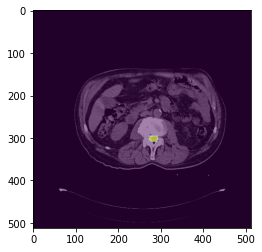

In [27]:
plt.imshow(window_levelled_slices_train[7,...], cmap='Greys_r')
plt.imshow(train_mask_slices[7,...].squeeze(), alpha=0.5)

If you've been paying attention, you will know that we have ~5000 images to train on. That's a lot. To make training a bit more tractable, I will now randomly select ~1500 training examples and ~500 validation ones. Ideally, you would just use the whole dataset, but we will either run out of memory or time if we do. We set the numpy random seed to a known value so everyone should get roughly the same results, then re-seed randomly afterwards so nothing else is affected.

In [28]:
np.random.seed(12345)
subset_indices = np.random.randint(0, window_levelled_slices_test.shape[0], size=1500)

wl_slice_subset_train = window_levelled_slices_train[subset_indices[0:1000]]
mask_subset_train = train_mask_slices[subset_indices[0:1000]]

wl_slice_subset_val = window_levelled_slices_train[subset_indices[-500:]]
mask_subset_val =  train_mask_slices[subset_indices[-500:]]

np.random.seed()

(1000, 512, 512)


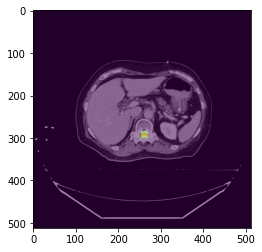

In [29]:
## Another sanity check to be sure that did what we expected...
plt.figure()
plt.imshow(wl_slice_subset_train[7,...], cmap='Greys_r')
plt.imshow(mask_subset_train[7,...].squeeze(), alpha=0.5)
print(wl_slice_subset_train.shape)
plt.show()

Now we can build the data loading, augmentation and normalisation pipeline. This is a little more involved in pytorch than in keras for example, but still isn't too difficult.

In the cell below, we create a subclass of the pytorch Dataset object, specific to our task. This class is made from three arguments - the array of images, the array of masks and a set of transformations we wish to apply. The two arrays are easy, we already have them ready to go, but the transformations may take a little bit of thinking.

These transformations are where we can introduce some data augmentation. Recall that data augmentation is the process of applying random transformations to our data to create "new" synthetic data to train our model with. We said at the beginning we would only use a little bit of data augmentation, namely horizontal flipping and a little bit of rotation. We will set that up in the next cell.

There are also some transformations that are more or less mandatory. For example, pytorch's pretrained models expect images to be of type float, and have a specific mean and standard deviation (derived from the imagenet dataset). We apply a transformation that handles normalisaing to the imagenet mean, and converting the array into a pytorch tensor so it can be sent through the model. Because we're working on a single channel, we normalise to the mean of means, and mean standard deviation across the RGB channels (This will hopefully make more sense in the code.)

We will use a library called albumentations to handle our augmentations. It is very fast and easy to use, but only works for 2D images. For 3D augmentations, there is a library called kornia which can do some augmentations.

It is important to note that we use different pipelines for the training and validation data. For training, we can do whatever we like to make the data go as far as possible, but when validating, we're meant to be getting an idea of the network's performance on 'real' data, so we should not do any augmentation. This is easy to do with the way things are set up.

In [37]:
## Define a subclass of Dataset that handles our image-mask pair loaded from arrays
## This is the bare minimum example!
class LCTSCDataGen(torch.utils.data.Dataset):
  def __init__(self, image_array, mask_array, transform):
    super().__init__()
    self.image_array = image_array
    self.mask_array = mask_array
    self.transform = transform

  def __len__(self):
    return self.image_array.shape[0]

  def __getitem__(self, idx):
    image = self.image_array[idx,...]
    mask = self.mask_array[idx, ...]
    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      image = transformed['image']
      mask = transformed['mask']
    # print(mask.shape)
    return image[np.newaxis,...], mask

## Now create the augmentation pipeline

train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(5),
    A.Normalize(mean=(np.mean([0.485, 0.456, 0.406])), std=(np.mean([0.229, 0.224, 0.225]))) ## Note mean of means, mean of stds
])

## valdation pipeline just does normalisation and conversion to tensor
val_transforms = A.Compose([
    A.Normalize(mean=(np.mean([0.485, 0.456, 0.406])), std=(np.mean([0.229, 0.224, 0.225]))) ## Note mean of means, mean of stds
])



## Now create some datasets and dataloaders
train_dataset = LCTSCDataGen(wl_slice_subset_train, mask_subset_train, train_transforms)
val_dataset = LCTSCDataGen(wl_slice_subset_val, mask_subset_val, val_transforms)

## Create dataloaders from these datasets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8)

print(mask_subset_train.shape, wl_slice_subset_train.shape)

(1000, 512, 512) (1000, 512, 512)


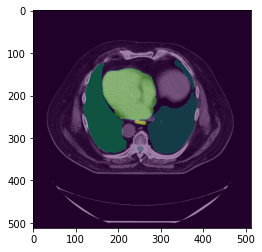

In [36]:
## One more sanity check...
train_img, train_msk = next(iter(train_dataloader))

# print(train_img.numpy()[3,...].shape)
# print(train_msk.numpy()[3,...].shape)
# print(train_msk.numpy()[3,250, 200], train_msk.numpy()[3,250,350])
plt.figure()
plt.imshow(train_img.numpy()[3,...].squeeze(), cmap='Greys_r')
plt.imshow(train_msk.numpy()[3,...].squeeze(), alpha=0.5)
plt.show()


# 3. Creating the Segmentation model

For simplicity, we are going to use a python library of pre-built segmentation networks. The library is called `segmentation_models` and I highly reccomend you have a look at the [github page](https://github.com/qubvel/segmentation_models.pytorch). We already imported the library at the top of the notebook, so we can use it straight away here.

We will be using a pre-trained segmentation model, in which the feature extraction parts of the network have been pre-trained on imagenet (A large database of natural images). This should mean we can train a good model with relatively little data, but also means we have to convert our 1 channel CT image into a 3 channel RGB image. Fortunately, the library can do the 1 -> 3 channel conversion for us by repeating the image in the channel dimension.

We will be using an architecture called a Feature Pyramid Network or [FPN](), it looks something like this:

![FPN architecture, from segmentation_models github page](https://github.com/qubvel/segmentation_models/raw/master/images/fpn.png)

The part on the left, in gray, is the bit that is pretrained on imagenet; this is called the backbone of the network. Pretraining means that the backbone already knows about some features in images that are useful, in this case to classify them. We will use these features as a starting point from which we will learn features useful to our task - segmentation in CT.

The choice of backbone is somewhat arbitrary - more modern and bigger networks should have better performance, but not always. We will use the smallest network available, ResNet-18 because it will hopefully train faster and use less GPU memory. 

As I alluded to at the beginning, writing/explaining a pytorch training loop in the ~1 hour we have is probably not realistic, so we are going to use a library called pytorch-lightning to do all the heavy lifting for us. To be able to use it, we have to wrap our pytorch model in a special class that inherits from a LightningModule (If none of that makes sense, don't worry - this bit is making the model so that pytorch-lightning knows what to do with it). To do the wrapping, we create a class LightningFPN, and define a few mandatory functions for pytorch-lightning to use.

While creating the wrapper, we also have to select which optimiser to use, and the most appropriate loss function for the problem. There are lots of considerations in selecting an optimiser, but most people use one of either Stochastic Gradient Descent (SGD) with momentum, or Adaptive Moment Estimation (Adam). Usually, Adam converges faster than SGD because of the fancy stuff it is doing inside the optimiser, but sometimes SGD can find a better solution by avoiding a local minimum. In the interests of speed, we will use Adam.

The choice of loss function can also have a profound impact on the quality of the trained model. There are a few loss functions we could consider here. Segmentation is just a classification problem applied to every pixel in the image, so we could use a loss designed for classification, apply it in every pixel and then take the average across the whole image. This is what the categorical crossentropy loss will do. Categorical crossentropy can fall over though - especially when there is a class imbalance. Since we are segmenting organs that occupy a small fraction of the image, we have a lot of background and not much foreground, therefore the loss will be dominated by the background. There are ways around this (e.g. weighted cross entropy, or focal loss) but as a first attempt, we should probably use something else.

The Dice similarity coefficient (DSC) is very well known, and can be used as a loss function here. DSC is rightly villified in radiotherapy because it has no spatial component (how far apart were the contours) and is very sensitive to volume (small contours will always be much worse than big ones). The segmentation_models library has implementations of all these losses; for now we will just use DSC, but it would be trivial to use one of the other losses.


In [38]:
## Define the class that will wrap te pytorch model up for ptl
class LightningFPN(pl.LightningModule):
  def __init__(self):
    super().__init__()
    ## Create the pytorch model 
    self.model = smp.FPN("resnet18", in_channels=1, classes=len(structure_names)+1, encoder_weights='imagenet')
    
    ## Construct a loss function, this is DSC, configured for multiple classes, and ignoring the background
    self.loss_fcn = smp.losses.DiceLoss("multiclass", from_logits=True, ignore_index=0)

    ## Specify which optimiser to use here
    self.optimizer = torch.optim.Adam

  def forward(self, x):
    return self.model(x)

  def configure_optimizers(self):
    optimizer = self.optimizer(self.parameters(), lr=1e-4)## May need to handle other kwargs here!
    return {"optimizer": optimizer, "reduce_on_plateau":True}
    ## Note - we are reducing the learning rate when the validation loss plateaus for a while - this should improve the model


  def training_step(self, batch, batch_idx):
    img, msk = batch
    msk_hat = self(img)
    loss = self.loss_fcn(msk_hat, msk.long())
    self.log("loss", loss)
    return loss

  def validation_step(self, batch, batch_idx):
    img, msk = batch
    msk_hat = self(img)
    val_loss = self.loss_fcn(msk_hat, msk.long())
    self.log("val_loss", val_loss)
    return val_loss


## Now we can wrap the prebuilt model up inside a pytorch lightning module:

pl_model = LightningFPN()

## Done!


This model has about 13 million parameters, which might stretch our GPU a bit - we will need to think about batch size if this becomes an issue during training.

# 4. Training

We're now ready to train the model. It is very easy when using pytorch-lightning, only taking 2 lines to do what would be hundreds in pure pytorch!

To be able to keep track of what is going on, we will use the tensorboard log viewer, which I activate in the next cell. This will allow us to see the training and validation loss change as the network learns.

To keep things quick, we will only train for 5 epochs. Ideally, we would train for a few hundred, to make sure the network loss is properly saturated.


In [ ]:
%tensorboard --logdir lightning_logs/

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=5)
trainer.fit(pl_model, train_dataloader, val_dataloader)

You should be able to see the training progress in the tensorboard browser. 5 epochs is not enough, but as we will see, it is actually surprisingly good...

We can now try running this model on some test data. I've chosen a slice somewhat at random so that it has all the structures, in a moment we will run the segmentation over the whole test set.


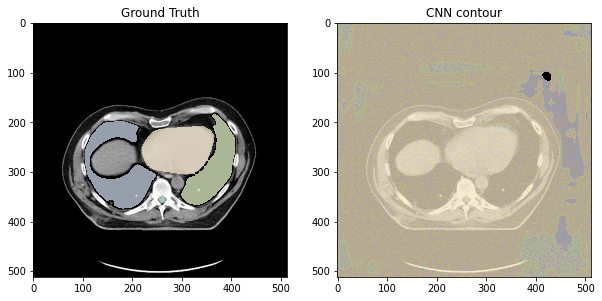

In [53]:
idx = test_pt_lengths[0]//3
## Note - we have to manually expand the channel dimension
in_image = val_transforms(image=window_levelled_slices_test[idx:idx+1,:,:][:,np.newaxis,...])['image'] 

gt = test_mask_slices[idx:idx+1,...].astype(np.float32)
gt[gt == 0.0] = np.nan ## make the background invisible

test = pl_model.model.predict(torch.tensor(in_image)).detach() ## the model dosn't do softmax activation, so we have to do it ourselves
probs = torch.nn.functional.softmax(test).numpy().squeeze()
test_mask = np.argmax(probs, axis=0).astype(np.float)
test_mask[test_mask == 0.0] = np.nan


## Show the results
fig =  plt.figure(figsize=(10,10)) 
ax_gt = fig.add_subplot(121)
ax_gt.set_title("Ground Truth")
ax_cnn = fig.add_subplot(122)
ax_cnn.set_title("CNN contour")

ax_gt.imshow(in_image.squeeze(), cmap='Greys_r')
ax_gt.imshow(gt.squeeze(), alpha=0.75, cmap='Pastel2', vmin=1, vmax=5)

ax_cnn.imshow(in_image.squeeze(), cmap='Greys_r')
ax_cnn.imshow(test_mask, alpha=0.75, cmap='Pastel2', vmin=1, vmax=5)

Again, to keep this from taking all day, I have pre-trained a model on the exact same data as here, but for 200 epochs

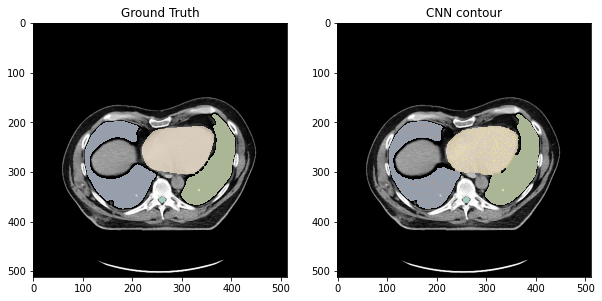

In [54]:
model_trained = pl_model.load_from_checkpoint("E:/code/RadNetPractical/pretrained_checkpoint.ckpt")

in_image = val_transforms(image=window_levelled_slices_test[idx:idx+1,:,:][:,np.newaxis,...])['image'] 

gt = test_mask_slices[idx,...].astype(np.float32)
gt[gt == 0.0] = np.nan

test = model_trained.model.predict(torch.tensor(in_image)).detach() ## the model dosn't do softmax activation, so we have to do it ourselves
probs = torch.nn.functional.softmax(test).numpy().squeeze()
test_mask = np.argmax(probs, axis=0).astype(np.float)
test_mask[test_mask == 0.0] = np.nan

## Show the results
fig =  plt.figure(figsize=(10,10)) 
ax_gt = fig.add_subplot(121)
ax_gt.set_title("Ground Truth")
ax_cnn = fig.add_subplot(122)
ax_cnn.set_title("CNN contour")

ax_gt.imshow(in_image.squeeze(), cmap='Greys_r')
ax_gt.imshow(gt.squeeze(), alpha=0.75, cmap='Pastel2', vmin=1, vmax=5)

ax_cnn.imshow(in_image.squeeze(), cmap='Greys_r')
ax_cnn.imshow(test_mask, alpha=0.75, cmap='Pastel2', vmin=1, vmax=5)


# 5. Evaluation

Visually, the results look pretty good, but now let's try to quantify it a bit. We're going to use a few metrics: 
- Dice Coefficient - the same things as what we used for the loss, just measures overlap and is sensitive to 
- Mean surface distance - The mean of the directed hausdorf distance from GT -> CNN and CNN -> GT
- 95th percentile Hausdorff distance - the mean of the directed 95th percentile HD from GT -> CNN and CNN -> GT

These are the same metrics as used in the original AAPM challenge. Unfortunately, I don't have access to the reference values used in the calculation of the score, otherwise we could see where we rank!

The cell below defines some functions to help us segment in 3D and calculate the metrics

In [181]:
def segment_3d(image, model, transforms):
    batch_size = 8
    whole_batches = image.shape[0] // batch_size
    batch_splitpoints = [(a*batch_size, a*batch_size + batch_size) for a in  range(whole_batches)]

    ## do things on GPU
    model.cuda()

    if image.shape[0] % batch_size != 0:
        last_batch_start_idx = whole_batches * batch_size
        last_batch_size = image.shape[0] - last_batch_start_idx
        batch_splitpoints.append((last_batch_start_idx, image.shape[0]))
    
    segmentation = np.zeros_like(image)
    for b_start, b_stop in batch_splitpoints:
        transformed_image = torch.tensor(transforms(image=image[b_start:b_stop])['image']).cuda()
        logits = model.predict(transformed_image[:, np.newaxis,...]).cpu()
        probs = torch.nn.functional.softmax(logits)
        segmentation[b_start:b_stop,...] = np.argmax(probs, axis=1)
    return segmentation

def mask_2_contour(mask, origin, pixel_size):
    """
    Gives back corrdinates on the contours in mm, in the same FoR as the original DICOM

    This is only a little step from being able to write an RTSTRUCT file...
    """
    slice_structures = {}
    for structure_idx in range(len(structure_names)):
        structure_name = structure_names[structure_idx]
        struc = np.zeros_like(mask, dtype=np.uint8)
        struc[mask == structure_idx+1] = 255  ## Structure ID is index +1
        contours, hierachy = cv2.findContours(struc, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        slice_structures[structure_name] = []

        for c in contours:
            if cv2.contourArea(c) < 50: ## ignore tiny contours - should remove little blobs segmented by the network
                continue
                
                
            if len(c) > 1:
                contour_y = c.squeeze()[:,0]
                contour_x = c.squeeze()[:,1]
                x_pixel, y_pixel = pixel_size
                x_origin, y_origin, z_origin = origin


                # y, x is how it's mapped
                dicom_coords = [( (y*y_pixel) + y_origin, (x * x_pixel) + x_origin, z_origin ) for x, y in zip(contour_y, contour_x) ]
                slice_structures[structure_name].append(dicom_coords)
    return slice_structures

def mask_2_contour_3d(mask, origins, pixel_sizes):
    """
    Calculate contours on each slice independently, then build into list for 3D
    """
    all_structure_contours = {sn:[] for sn in structure_names}
    for mask_slice, origin, pixel in zip(mask, origins, pixel_sizes):
        this_slice_structures = mask_2_contour(mask_slice, origin, pixel)

        for structure_name in structure_names:
            all_structure_contours[structure_name].extend(this_slice_structures[structure_name])
    return all_structure_contours


def dice_coefficient(gt, cnn):
    dice_summary = {}
    for structure_name in structure_names:
        structure_idx = structure_names.index(structure_name) + 1
        dice = np.sum(np.logical_and(gt==structure_idx, cnn==structure_idx))*2.0 / (np.sum(cnn==structure_idx) + np.sum(gt==structure_idx) )
        dice_summary[structure_name] = dice
    return dice_summary

def mean_surface_distance(gt, cnn):
    """
    Calculate undirected HD both ways then return average
    """
    r1, i1, i2 = directed_hausdorff(gt, cnn)
    r2, i1, i2 = directed_hausdorff(gt, cnn)

    return (r1 + r2)/2 

def hausdorff_distances(points_gt, points_cnn):
    """
    Inspiration from https://github.com/hjkuijf/wmhchallenge/blob/master/evaluation.py

    Gives the same values as scipy directed_hausdorff when percentile is changed to max, so I *think* it is correct
    """
    def getDistancesFromAtoB(a, b):    
        kdTree = KDTree(a, leafsize=100)
        return kdTree.query(b, k=1, eps=0, p=2)[0]

    # Compute distances from test to result; and result to test
    dTestToResult = getDistancesFromAtoB(points_gt, points_cnn)
    dResultToTest = getDistancesFromAtoB(points_cnn, points_gt)    
    
    return max(np.percentile(dTestToResult, 95) , np.percentile(dResultToTest, 95))

In [152]:
## first segment the image in 3D by running on every slice
idx = test_pt_lengths[0]
test_segmentation = segment_3d(window_levelled_slices_test[0:idx,:,:], model_trained.model, val_transforms)
gt = test_mask_slices[0:idx,...]

In [172]:

gt_contours = mask_2_contour_3d(gt, test_slice_locations[0:idx], test_pixel_sizes[0:idx])

## Only compare where GT has contours
comparison_indices = np.sum(gt, axis=(1,2)) > 0

cnn_contours = mask_2_contour_3d(test_segmentation[comparison_indices,...], test_slice_locations[0:idx][comparison_indices], test_pixel_sizes[0:idx][comparison_indices])


## calculate DSC
dice_test = dice_coefficient(gt[comparison_indices,...], test_segmentation[comparison_indices,...])
print(dice_test)


(130, 512, 512)
{'SpinalCord': 0.9292187312866781, 'Lung_R': 0.9780532685136806, 'Lung_L': 0.9760957069477777, 'Heart': 0.9211673444630792, 'Esophagus': 0.7519742505333283}


In [182]:
all_cnn = {name : [] for name in structure_names}
all_gt = {name : [] for name in structure_names}

distance_measures = {name : {} for name in structure_names}

for name in structure_names:
    [all_cnn[name].extend(list(a)) for a in cnn_contours[name]]
    all_cnn[name] = np.array(all_cnn[name])

    [all_gt[name].extend(list(a)) for a in gt_contours[name]]
    all_gt[name] = np.array(all_gt[name])

    distance_measures[name]['msd'] = mean_surface_distance(all_gt[name], all_cnn[name])
    distance_measures[name]["95HD"] = hausdorff_distances(all_gt[name], all_cnn[name])


print(distance_measures)




{'SpinalCord': {'msd': 4.882810000000006, '95HD': 2.7621344497963927}, 'Lung_R': {'msd': 12.342939174320204, '95HD': 3.521044364669669}, 'Lung_L': {'msd': 13.671868000000018, '95HD': 3.5797616344354566}, 'Heart': {'msd': 16.91257206193121, '95HD': 10.973238419218562}, 'Esophagus': {'msd': 5.94019474211307, '95HD': 14.149528878393786}}
